# 08 — Neural Networks

This notebook builds deep learning models for HAR using PyTorch:
1. **MLP (Multi-Layer Perceptron)** — on engineered features
2. **1D CNN** — on raw windowed time-series data

Both models include dropout, batch normalization, and learning rate scheduling.
We compare their performance against classical ML models.

---

## 8.1 — Imports and Configuration

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import time
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}')

sns.set_theme(style='whitegrid', palette='deep', font_scale=1.1)

# Hyperparameters
BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 1e-3
PATIENCE = 10  # early stopping

DATA_DIR = Path('processed_data')

with open(DATA_DIR / 'metadata.json') as f:
    meta = json.load(f)
ACTIVITY_MAP = {int(k): v for k, v in meta['activity_map'].items()}
activity_names = [ACTIVITY_MAP[i] for i in sorted(ACTIVITY_MAP.keys())]
N_CLASSES = len(activity_names)

print(f'Classes: {N_CLASSES} — {activity_names}')

Device: cpu
Classes: 6 — ['Standing', 'Walking', 'Sitting', 'Lying Down', 'Going Upstairs', 'Going Downstairs']


## 8.2 — Load Data

We load two versions:
- **Engineered features** → for MLP
- **Raw windowed data** → for 1D CNN

In [11]:
# For MLP: engineered features
X_train_feat = pd.read_csv(DATA_DIR / 'X_train_features_selected.csv').values
X_test_feat  = pd.read_csv(DATA_DIR / 'X_test_features_selected.csv').values
y_train = np.load(DATA_DIR / 'y_train.npy')
y_test  = np.load(DATA_DIR / 'y_test.npy')

# Handle NaN/Inf
X_train_feat = np.nan_to_num(X_train_feat, nan=0.0, posinf=0.0, neginf=0.0)
X_test_feat  = np.nan_to_num(X_test_feat, nan=0.0, posinf=0.0, neginf=0.0)

# For CNN: raw windowed data
X_train_raw = np.load(DATA_DIR / 'X_train.npy')  # (n, 128, 30)
X_test_raw  = np.load(DATA_DIR / 'X_test.npy')

# Create validation split from train (80/20)
X_tr_feat, X_val_feat, y_tr, y_val = train_test_split(
    X_train_feat, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)
X_tr_raw, X_val_raw, _, _ = train_test_split(
    X_train_raw, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

print(f'MLP  — Train: {X_tr_feat.shape}, Val: {X_val_feat.shape}, Test: {X_test_feat.shape}')
print(f'CNN  — Train: {X_tr_raw.shape}, Val: {X_val_raw.shape}, Test: {X_test_raw.shape}')

MLP  — Train: (65548, 100), Val: (16387, 100), Test: (28570, 100)
CNN  — Train: (65548, 128, 30), Val: (16387, 128, 30), Test: (28570, 128, 30)


In [12]:
# Create DataLoaders
def make_loaders(X_tr, X_val, X_te, y_tr, y_val, y_te, batch_size):
    train_ds = TensorDataset(torch.FloatTensor(X_tr), torch.LongTensor(y_tr))
    val_ds   = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    test_ds  = TensorDataset(torch.FloatTensor(X_te), torch.LongTensor(y_te))
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size)
    test_loader  = DataLoader(test_ds, batch_size=batch_size)
    
    return train_loader, val_loader, test_loader

# MLP loaders
mlp_train, mlp_val, mlp_test = make_loaders(
    X_tr_feat, X_val_feat, X_test_feat, y_tr, y_val, y_test, BATCH_SIZE
)

# CNN loaders (transpose to channels-first: n, features, time)
X_tr_cnn  = X_tr_raw.transpose(0, 2, 1)   # (n, 30, 128)
X_val_cnn = X_val_raw.transpose(0, 2, 1)
X_te_cnn  = X_test_raw.transpose(0, 2, 1)

cnn_train, cnn_val, cnn_test = make_loaders(
    X_tr_cnn, X_val_cnn, X_te_cnn, y_tr, y_val, y_test, BATCH_SIZE
)

print('DataLoaders ready.')

DataLoaders ready.


## 8.3 — MLP Model

A three-hidden-layer MLP with batch normalization and dropout.

In [13]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, n_classes, hidden_dims=[256, 128, 64], dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, h_dim),
                nn.BatchNorm1d(h_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, n_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.net(x)

input_dim = X_tr_feat.shape[1]
mlp_model = MLPClassifier(input_dim, N_CLASSES).to(DEVICE)
print(mlp_model)
print(f'\nTotal parameters: {sum(p.numel() for p in mlp_model.parameters()):,}')

MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=128, out_features=64, bias=True)
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=6, bias=True)
  )
)

Total parameters: 68,294


## 8.4 — Training Loop (Shared)

In [14]:
def train_model(model, train_loader, val_loader, epochs, lr, patience, device):
    """
    Train a PyTorch model with early stopping.
    Returns training history.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5,
                                                     factor=0.5)
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0
    
    for epoch in range(epochs):
        # === Training ===
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * len(y_batch)
            train_correct += (outputs.argmax(1) == y_batch).sum().item()
            train_total += len(y_batch)
        
        # === Validation ===
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item() * len(y_batch)
                val_correct += (outputs.argmax(1) == y_batch).sum().item()
                val_total += len(y_batch)
        
        # Metrics
        epoch_train_loss = train_loss / train_total
        epoch_val_loss = val_loss / val_total
        epoch_train_acc = train_correct / train_total
        epoch_val_acc = val_correct / val_total
        
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)
        
        scheduler.step(epoch_val_loss)
        
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'  Epoch {epoch+1:3d}/{epochs} — '
                  f'Train: loss={epoch_train_loss:.4f} acc={epoch_train_acc:.4f} | '
                  f'Val: loss={epoch_val_loss:.4f} acc={epoch_val_acc:.4f}')
        
        if patience_counter >= patience:
            print(f'  Early stopping at epoch {epoch+1}')
            break
    
    # Restore best model
    if best_state is not None:
        model.load_state_dict(best_state)
    
    return history


def evaluate_nn(model, test_loader, device):
    """Evaluate a PyTorch model on test data."""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(y_batch.numpy())
    return np.array(all_preds), np.array(all_labels)


def plot_training_curves(history, title):
    """Plot training and validation loss/accuracy curves."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    axes[0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0].plot(history['val_loss'], label='Validation', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title(f'{title} — Loss', fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[1].plot(history['val_acc'], label='Validation', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title(f'{title} — Accuracy', fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

## 8.5 — Train MLP

Training MLP...
  Epoch   1/50 — Train: loss=0.6639 acc=0.7979 | Val: loss=0.4590 acc=0.8535
  Epoch   5/50 — Train: loss=0.4479 acc=0.8649 | Val: loss=0.4186 acc=0.8696
  Epoch  10/50 — Train: loss=0.4194 acc=0.8756 | Val: loss=0.3577 acc=0.8964
  Epoch  15/50 — Train: loss=0.4082 acc=0.8794 | Val: loss=0.3542 acc=0.8989
  Epoch  20/50 — Train: loss=0.3957 acc=0.8836 | Val: loss=0.3501 acc=0.8994
  Epoch  25/50 — Train: loss=0.3926 acc=0.8844 | Val: loss=0.3482 acc=0.8966
  Epoch  30/50 — Train: loss=0.3892 acc=0.8859 | Val: loss=0.3569 acc=0.8967
  Epoch  35/50 — Train: loss=0.3864 acc=0.8874 | Val: loss=0.5226 acc=0.8081
  Epoch  40/50 — Train: loss=0.3859 acc=0.8852 | Val: loss=0.3754 acc=0.8833
  Epoch  45/50 — Train: loss=0.3807 acc=0.8871 | Val: loss=0.3539 acc=0.8907
  Epoch  50/50 — Train: loss=0.3721 acc=0.8896 | Val: loss=0.3588 acc=0.8914
Training time: 110.1s


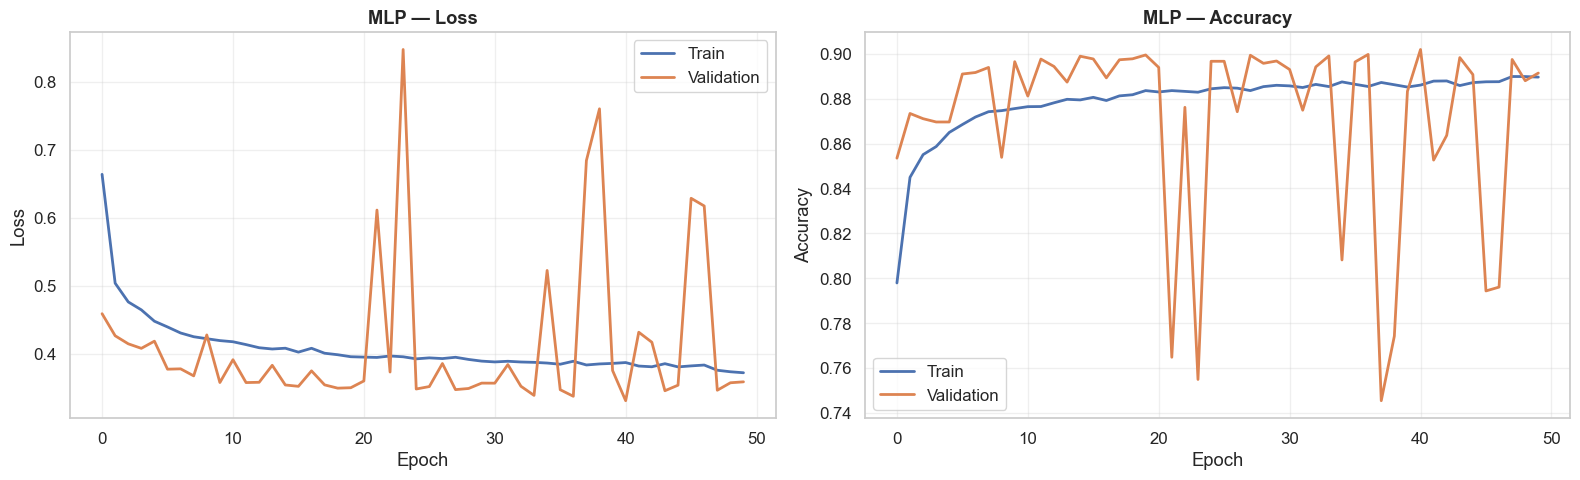

In [15]:
print('Training MLP...')
t0 = time.time()
mlp_history = train_model(mlp_model, mlp_train, mlp_val, EPOCHS, LEARNING_RATE, PATIENCE, DEVICE)
mlp_time = time.time() - t0
print(f'Training time: {mlp_time:.1f}s')

fig = plot_training_curves(mlp_history, 'MLP')
plt.savefig('mlp_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [16]:
# Evaluate MLP
mlp_preds, mlp_labels = evaluate_nn(mlp_model, mlp_test, DEVICE)
mlp_acc = accuracy_score(mlp_labels, mlp_preds)
mlp_f1 = f1_score(mlp_labels, mlp_preds, average='weighted')

print(f'MLP Test Accuracy: {mlp_acc:.4f}')
print(f'MLP Test F1: {mlp_f1:.4f}')
print(f'\nClassification Report:')
print(classification_report(mlp_labels, mlp_preds, target_names=activity_names, digits=4))

MLP Test Accuracy: 0.9096
MLP Test F1: 0.9103

Classification Report:
                  precision    recall  f1-score   support

        Standing     0.9661    0.9234    0.9442      8574
         Walking     0.8151    0.9043    0.8574      3909
         Sitting     0.8384    0.9404    0.8865      3994
      Lying Down     0.9498    0.8857    0.9166      4041
  Going Upstairs     0.9062    0.9361    0.9209      3973
Going Downstairs     0.9441    0.8532    0.8963      4079

        accuracy                         0.9096     28570
       macro avg     0.9033    0.9072    0.9037     28570
    weighted avg     0.9138    0.9096    0.9103     28570



## 8.6 — 1D CNN Model

A 1D CNN processes the raw time-series windows directly, learning temporal
features via convolutional filters.

In [17]:
class CNN1DClassifier(nn.Module):
    def __init__(self, n_channels, seq_len, n_classes, dropout=0.3):
        super().__init__()
        self.conv_block = nn.Sequential(
            # Block 1
            nn.Conv1d(n_channels, 64, kernel_size=5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            
            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout),
            
            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, n_classes)
        )
    
    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

n_channels = X_tr_cnn.shape[1]  # 30
seq_len = X_tr_cnn.shape[2]     # 128

cnn_model = CNN1DClassifier(n_channels, seq_len, N_CLASSES).to(DEVICE)
print(cnn_model)
print(f'\nTotal parameters: {sum(p.numel() for p in cnn_model.parameters()):,}')

CNN1DClassifier(
  (conv_block): Sequential(
    (0): Conv1d(30, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.3, inplace=False)
    (5): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (6): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): AdaptiveAvgPool1d(output_size=1)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=256, out_features=128, bias=True)


## 8.7 — Train 1D CNN

Training 1D CNN...
  Epoch   1/50 — Train: loss=0.0816 acc=0.9748 | Val: loss=0.0798 acc=0.9739
  Epoch   5/50 — Train: loss=0.0787 acc=0.9759 | Val: loss=0.0613 acc=0.9803
  Epoch  10/50 — Train: loss=0.0482 acc=0.9842 | Val: loss=0.0637 acc=0.9812
  Epoch  15/50 — Train: loss=0.0506 acc=0.9831 | Val: loss=0.0506 acc=0.9836
  Epoch  20/50 — Train: loss=0.0386 acc=0.9871 | Val: loss=0.0482 acc=0.9848
  Epoch  25/50 — Train: loss=0.0279 acc=0.9908 | Val: loss=0.0350 acc=0.9886
  Epoch  30/50 — Train: loss=0.0240 acc=0.9921 | Val: loss=0.0348 acc=0.9888
  Epoch  35/50 — Train: loss=0.0183 acc=0.9939 | Val: loss=0.0334 acc=0.9894
  Epoch  40/50 — Train: loss=0.0153 acc=0.9949 | Val: loss=0.0295 acc=0.9912
  Epoch  45/50 — Train: loss=0.0174 acc=0.9946 | Val: loss=0.0290 acc=0.9908
  Epoch  50/50 — Train: loss=0.0137 acc=0.9955 | Val: loss=0.0305 acc=0.9909
Training time: 2361.6s


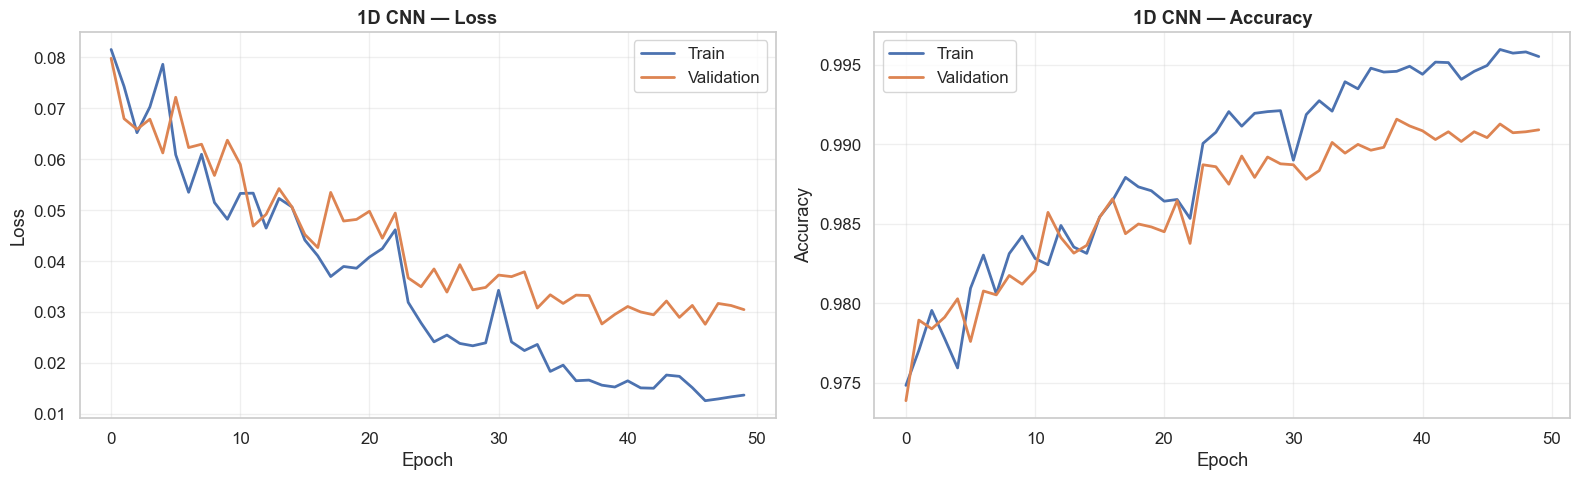

In [19]:
print('Training 1D CNN...')
t0 = time.time()
cnn_history = train_model(cnn_model, cnn_train, cnn_val, EPOCHS, LEARNING_RATE, PATIENCE, DEVICE)
cnn_time = time.time() - t0
print(f'Training time: {cnn_time:.1f}s')

fig = plot_training_curves(cnn_history, '1D CNN')
plt.savefig('cnn_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# Evaluate CNN
cnn_preds, cnn_labels = evaluate_nn(cnn_model, cnn_test, DEVICE)
cnn_acc = accuracy_score(cnn_labels, cnn_preds)
cnn_f1 = f1_score(cnn_labels, cnn_preds, average='weighted')

print(f'1D CNN Test Accuracy: {cnn_acc:.4f}')
print(f'1D CNN Test F1: {cnn_f1:.4f}')
print(f'\nClassification Report:')
print(classification_report(cnn_labels, cnn_preds, target_names=activity_names, digits=4))

1D CNN Test Accuracy: 0.9322
1D CNN Test F1: 0.9324

Classification Report:
                  precision    recall  f1-score   support

        Standing     0.9392    0.9097    0.9242      8574
         Walking     0.9768    0.9570    0.9668      3909
         Sitting     0.8691    0.9306    0.8988      3994
      Lying Down     0.9398    0.9463    0.9430      4041
  Going Upstairs     0.9242    0.9446    0.9343      3973
Going Downstairs     0.9429    0.9311    0.9370      4079

        accuracy                         0.9322     28570
       macro avg     0.9320    0.9366    0.9340     28570
    weighted avg     0.9331    0.9322    0.9324     28570



## 8.8 — Confusion Matrices

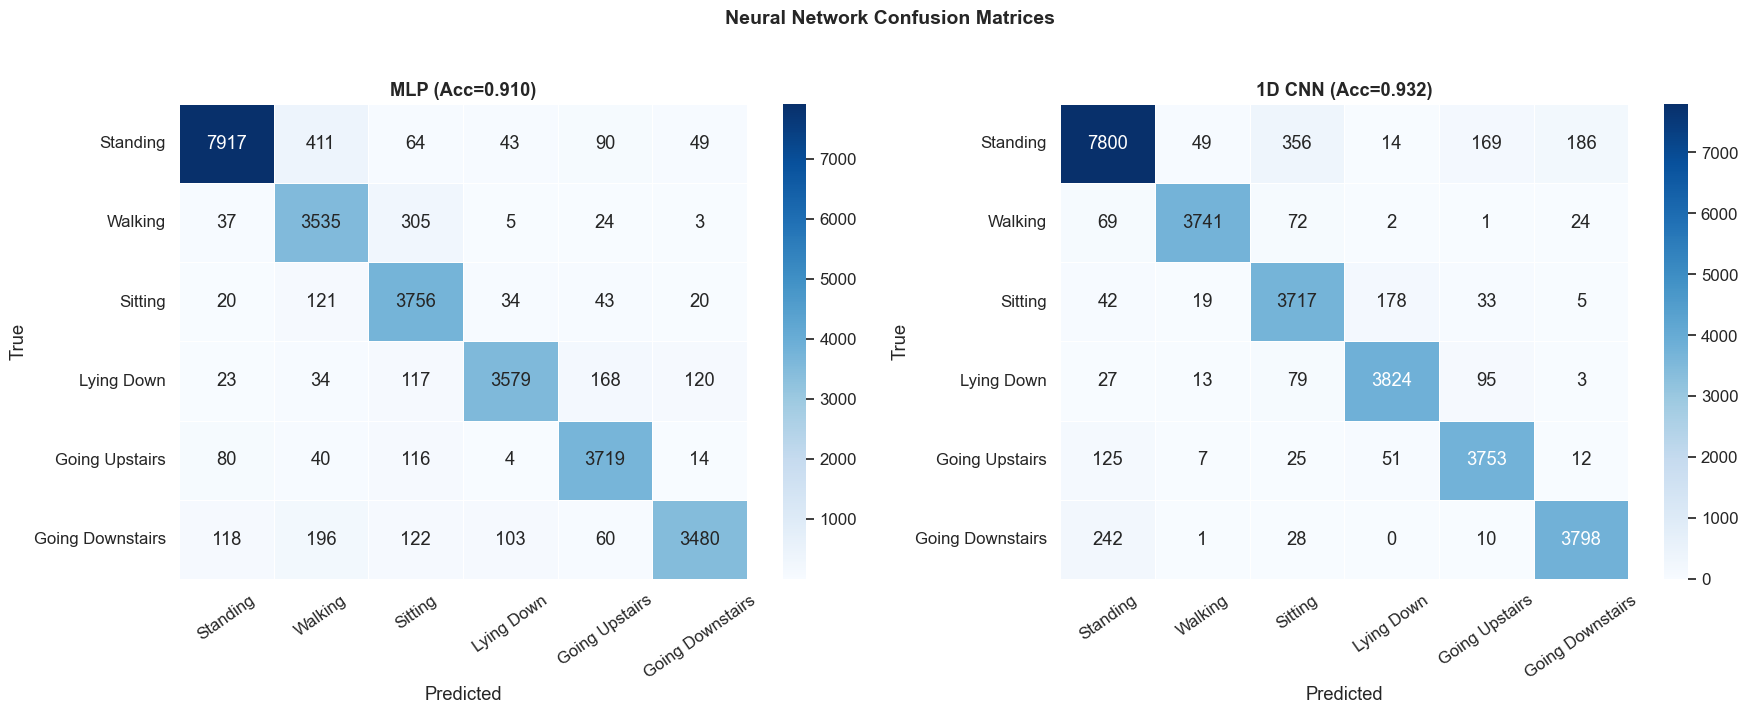

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for ax, preds, labels_true, name, acc in [
    (axes[0], mlp_preds, mlp_labels, 'MLP', mlp_acc),
    (axes[1], cnn_preds, cnn_labels, '1D CNN', cnn_acc)
]:
    cm = confusion_matrix(labels_true, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=activity_names, yticklabels=activity_names, linewidths=0.5)
    ax.set_title(f'{name} (Acc={acc:.3f})', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.tick_params(axis='x', rotation=35)

plt.suptitle('Neural Network Confusion Matrices', fontweight='bold', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('nn_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

## 8.9 — Neural Networks vs Classical ML Comparison

In [22]:
# Load classical ML results (from notebook 06 CSV)
try:
    classical_df = pd.read_csv('model_comparison_supervised.csv')
    print('Classical ML results loaded.')
    print(classical_df.to_string(index=False))
except FileNotFoundError:
    print('No classical ML results file found. Using placeholder values.')
    classical_df = pd.DataFrame({
        'Model': ['Logistic Regression', 'Random Forest', 'SVM', 'Gradient Boosting'],
        'Test Accuracy': ['N/A', 'N/A', 'N/A', 'N/A'],
        'Test F1 (weighted)': ['N/A', 'N/A', 'N/A', 'N/A']
    })

# Add neural network results
nn_results = pd.DataFrame([
    {'Model': 'MLP (PyTorch)', 'Test Accuracy': f'{mlp_acc:.4f}',
     'Test F1 (weighted)': f'{mlp_f1:.4f}', 'Train Time (s)': f'{mlp_time:.1f}'},
    {'Model': '1D CNN (PyTorch)', 'Test Accuracy': f'{cnn_acc:.4f}',
     'Test F1 (weighted)': f'{cnn_f1:.4f}', 'Train Time (s)': f'{cnn_time:.1f}'}
])

print('\n' + '='*70)
print('NEURAL NETWORK RESULTS')
print('='*70)
print(nn_results.to_string(index=False))

Classical ML results loaded.
              Model     CV Accuracy  Test Accuracy  Test F1 (weighted)  Train Time (s)
Logistic Regression 0.8497 ± 0.0081         0.8533              0.8435             8.8
      Random Forest 0.9579 ± 0.0028         0.9706              0.9706            12.1
                SVM 0.8762 ± 0.0056         0.8848              0.8845            12.9
  Gradient Boosting 0.9717 ± 0.0032         0.9712              0.9711             9.3

NEURAL NETWORK RESULTS
           Model Test Accuracy Test F1 (weighted) Train Time (s)
   MLP (PyTorch)        0.9096             0.9103          110.1
1D CNN (PyTorch)        0.9322             0.9324         2361.6


In [23]:
# Save models
model_dir = Path('models')
model_dir.mkdir(exist_ok=True)

torch.save(mlp_model.state_dict(), model_dir / 'mlp_model.pth')
torch.save(cnn_model.state_dict(), model_dir / 'cnn_1d_model.pth')
print('✅ Neural network models saved.')

✅ Neural network models saved.


## 8.10 — Summary

**Key findings:**
- **MLP** applied to engineered features provides competitive performance with
  classical ML models. The hand-crafted features capture most of the discriminative
  information.
- **1D CNN** learns directly from raw time-series and captures temporal patterns
  via convolutional filters. It can discover features that hand-crafting might miss.
- Both neural network models benefit from regularization (dropout, batch norm)
  and early stopping to prevent overfitting.
- The train/validation curves help diagnose over/underfitting.

**Classical ML vs Neural Networks:**
- Classical ML (especially tuned Random Forest / GBT) remains very competitive
  for tabular / engineered features.
- 1D CNN is most advantageous when working with raw sensor data, avoiding the
  need for manual feature engineering.
- For this dataset, the gap may be modest — the engineered features are quite good.

**Next:** MLflow experiment tracking in `09_Experiment_Tracking_with_MLflow.ipynb`.